<a href="https://colab.research.google.com/github/NefChr/Test8/blob/main/%CE%A0%CE%A1%CE%91%CE%9A%CE%A4%CE%99%CE%9A%CE%97_%CE%91%CE%A3%CE%9A%CE%97%CE%A3%CE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import logging
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingClassifier

In [26]:
# Φόρτωση των δεδομένων από το GitHub με χρήση της επιλογής low_memory=False
url = 'https://github.com/kdemertzis/EKPA/raw/main/Data/DarkNet.csv'
data = pd.read_csv(url, low_memory=False)

In [27]:
# Εμφάνιση των πρώτων γραμμών του συνόλου δεδομένων για να κατανοήσουμε τη δομή του
print(data.head())

          Src_IP  Src_Port          Dst_IP  Dst_Port  Protocol  Flow_Duration  \
0  10.152.152.11     57158   216.58.220.99       443         6            229   
1  10.152.152.11     57159   216.58.220.99       443         6            407   
2  10.152.152.11     57160   216.58.220.99       443         6            431   
3  10.152.152.11     49134  74.125.136.120       443         6            359   
4  10.152.152.11     34697  173.194.65.127     19305         6       10778451   

   Total_Fwd_Packet  Total_Bwd_packets  Total_Length_of_Fwd_Packet  \
0                 1                  1                           0   
1                 1                  1                           0   
2                 1                  1                           0   
3                 1                  1                           0   
4               591                400                       64530   

   Total_Length_of_Bwd_Packet  ...  Active_Mean  Active_Std  Active_Max  \
0                

In [28]:
# Αντικατάσταση των τιμών '?' με NaN
data.replace('?', np.nan, inplace=True)

In [29]:
# Αντικατάσταση των άπειρων τιμών με NaN στις αριθμητικές στήλες
for column in data.select_dtypes(include=[np.number]).columns:
    data[column].replace([np.inf, -np.inf], np.nan, inplace=True)

In [30]:
# Γέμισμα των κενών τιμών με την μέση τιμή (για αριθμητικές στήλες) ή την συχνότερη τιμή (για κατηγορηματικές στήλες)
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].mean(), inplace=True)

In [31]:
# Κωδικοποίηση κατηγορικών στηλών με One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=['Src_IP', 'Dst_IP', 'Label-1', 'Label-2'])

In [32]:
# Διαχωρισμός χαρακτηριστικών (features) και ετικέτας (label)
# Χρησιμοποιούμε τη στήλη 'Label-2' ως ετικέτα για την ανίχνευση κακόβουλης δραστηριότητας
X = data.drop(['Label-2', 'Label-1', 'Src_IP', 'Dst_IP'], axis=1)  # Διαγραφή των στήλες που δεν χρειάζονται
y = data['Label-2']  # Ετικέτα που πρέπει να προβλεφθεί

In [33]:
# Εμφάνιση των μοναδικών τιμών της ετικέτας για να δούμε τις κατηγορίες
print(y.unique())

['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [34]:
# Διάσπαση των δεδομένων σε εκπαιδευτικό και επαληθευτικό σύνολο
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Εκπαίδευση του μοντέλου HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [37]:
# Πρόβλεψη στο επαληθευτικό σύνολο
y_pred = model.predict(X_test)

In [38]:
# Αξιολόγηση του μοντέλου
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')  # Εμφάνιση της ακρίβειας

Accuracy: 0.8071838242441917


In [39]:
# Εμφάνιση αναφοράς ταξινόμησης (classification report)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

AUDIO-STREAMING       0.92      0.79      0.85       442
Audio-Streaming       0.85      0.70      0.77      1805
       Browsing       0.77      0.86      0.82      1532
           Chat       0.65      0.88      0.75      3422
          Email       0.84      0.38      0.53      1840
  File-Transfer       0.88      0.86      0.87      3401
  File-transfer       0.08      0.21      0.12        24
            P2P       0.99      0.99      0.99      4150
           VOIP       0.67      0.47      0.55      1093
Video-Streaming       0.75      0.85      0.80      2793
Video-streaming       0.36      0.36      0.36        72

       accuracy                           0.81     20574
      macro avg       0.71      0.67      0.67     20574
   weighted avg       0.82      0.81      0.80     20574



In [40]:
# Εμφάνιση του confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 350    0   18    1    0   36    0    9    0   28    0]
 [   0 1265    8   25    2   36    1    0    1  436   31]
 [   0    2 1325    4    2  139    7    5    1   47    0]
 [   5   21   27 3013   72   36    7    3  158   79    1]
 [   1    6   11  984  703   38    6    2   78   11    0]
 [   6   34  155   51   36 2922   24   14   14  144    1]
 [   0    1    0    1    0   14    5    3    0    0    0]
 [   5    6   25    2    1    5    3 4102    0    1    0]
 [   1   10    2  502   14   19    3    0  510   30    2]
 [  12  120  147   24    3   75    5    7    3 2386   11]
 [   0   31    0    0    1    1    0    0    0   13   26]]


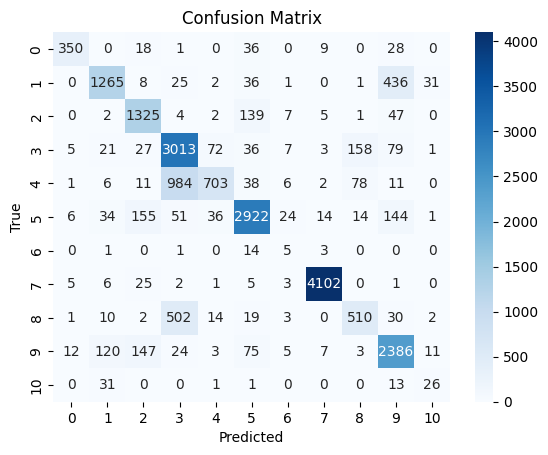

In [41]:
# Οπτικοποίηση του confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Δημιουργία και ρύθμιση του αρχείου καταγραφής
logging.basicConfig(filename='security_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [43]:
# Λειτουργία αντιμετώπισης κακόβουλης δραστηριότητας
def handle_malicious_activity(row):
    # Καταγραφή του περιστατικού
    logging.warning(f'Malicious activity detected: {row}')

    # Αποστολή ειδοποίησης μέσω email
    sender_email = "your_email@example.com"
    receiver_email = "admin@example.com"
    password = "your_password"

    message = MIMEMultipart("alternative")
    message["Subject"] = "Alert: Malicious Activity Detected"
    message["From"] = sender_email
    message["To"] = receiver_email

    text = f"""\
    Alert!
    Malicious activity detected:
    {row}
    """
    part = MIMEText(text, "plain")
    message.attach(part)

    with smtplib.SMTP_SSL("smtp.example.com", 465) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message.as_string())

    # Προσθήκη IP στη λίστα αποκλεισμένων IPs
    ip_to_block = row['Src_IP']
    with open('blocked_ips.txt', 'a') as file:
        file.write(f'{ip_to_block}\n')

In [46]:
# Έλεγχος και αντιμετώπιση κακόβουλης δραστηριότητας στα δεδομένα επαλήθευσης
for i, row in X_test.iterrows():
    if i < len(y_pred):  # Βεβαιωθείτε ότι ο δείκτης είναι εντός των ορίων του y_pred
        if y_pred[i] == 'Malicious':  # Υποθέτουμε ότι η κακόβουλη δραστηριότητα είναι σημειωμένη ως 'Malicious'
            handle_malicious_activity(row)